In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
from collections import Counter

from src.label import Label, lwrite, dknet_label_conversion
from os.path import splitext, basename, isdir, exists
from os import makedirs
from src.utils import crop_region, image_files_from_folder, nms
from darknet.python.darknet import detect
import darknet.python.darknet as dn

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import keras
from src.keras_utils import load_model
from glob import glob
from src.utils import im2single, getWH
from src.keras_utils import load_model, detect_lp
from src.label import Shape, writeShapes

Using TensorFlow backend.


# Unit Test

In [24]:
# For ALPR-Unscontrained
inp = "test/input"
outp = "test/output"
vehicle_threshold = .5
vehicle_weights = b'data/vehicle-detector/yolo-voc.weights'
vehicle_netcfg  = b'data/vehicle-detector/yolo-voc.cfg'
vehicle_dataset = b'data/vehicle-detector/voc.data'

In [2]:
# For Layout-Independent-alpr
inp = "test/input"
outp = "test/output2"
vehicle_threshold = .25
vehicle_weights = b'data/Layout-Independent-alpr/vehicle-detection.weights'
vehicle_netcfg  = b'data/Layout-Independent-alpr/vehicle-detection.cfg'
vehicle_dataset = b'data/Layout-Independent-alpr/vehicle-detection.data'

In [25]:
vehicle_net  = dn.load_net(vehicle_netcfg, vehicle_weights, 0)
vehicle_meta = dn.load_meta(vehicle_dataset) 
# For Layout-Independent-alpr, need to change the .name path described in .data file

In [26]:
imgs_paths = image_files_from_folder(inp)
imgs_paths.sort()

In [27]:
print(imgs_paths)

['test/input/AC_17.jpg', 'test/input/AC_18.jpg', 'test/input/AC_19.jpg', 'test/input/AC_20.jpg', 'test/input/LE_19.jpg', 'test/input/LE_20.jpg', 'test/input/LE_21.jpg', 'test/input/LE_22.jpg', 'test/input/RP_44.jpg', 'test/input/RP_45.jpg', 'test/input/RP_46.jpg', 'test/input/RP_47.jpg']


In [28]:
img_path = imgs_paths[8]
bname = basename(splitext(img_path)[0])
print(bname)

RP_44


In [29]:
R,_ = detect(vehicle_net, vehicle_meta, bytes(img_path, encoding='utf-8') ,thresh=vehicle_threshold)

In [30]:
print(R)

[(b'car', 0.9113456606864929, (178.58804321289062, 115.88402557373047, 289.2788391113281, 234.73760986328125)), (b'car', 0.767203152179718, (30.518112182617188, 94.46604919433594, 58.90771484375, 44.07699966430664))]


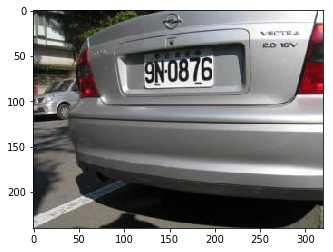

In [31]:
# Show original image
Iorig = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(Iorig, cv2.COLOR_BGR2RGB))
plt.show()

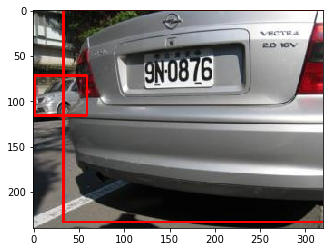

In [37]:
image = Iorig
color = (0,0,255) # Red in BGR
thickness = 2

for r in R:
    cx, cy, w, h = r[2]
    x_min = int(cx - w/2)
    y_min = int(cy - h/2)
    x_max = int(cx + w/2)
    y_max = int(cy + h/2)
    image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [32]:
WH = np.array(Iorig.shape[1::-1],dtype=float)
r = R[0]
cx,cy,w,h = (np.array(r[2])/np.concatenate( (WH,WH) )).tolist()
tl = np.array([cx - w/2., cy - h/2.])
br = np.array([cx + w/2., cy + h/2.])
label = Label(0,tl,br)
print(label)

Class: 0, top_left(x:0.106089,y:-0.006187), bottom_right(x:1.010086,y:0.971887)


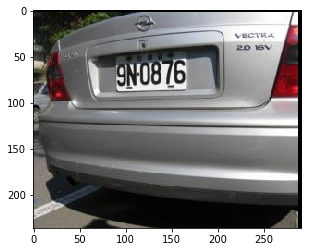

In [33]:
# Show the crop vehicle image
Icar = crop_region(Iorig,label)
img = np.uint8(Icar)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [24]:
### For ALPR-Unscontrained
lp_model = "data/lp-detector/wpod-net_update1.h5"
wpod_net = load_model(lp_model)

In [25]:
Ivehicle = img
ratio = float(max(Ivehicle.shape[:2]))/min(Ivehicle.shape[:2])
side  = int(ratio*288.)
bound_dim = min(side + (side%(2**4)),608)

In [27]:
lp_threshold = .5
Llp, LlpImgs, _ = detect_lp(wpod_net,im2single(Ivehicle),bound_dim,2**4,(240,80),lp_threshold)

In [28]:
print(len(LlpImgs))

1


In [29]:
Ilp = LlpImgs[0]
# Ilp = cv2.cvtColor(Ilp, cv2.COLOR_BGR2GRAY)
# Ilp = cv2.cvtColor(Ilp, cv2.COLOR_GRAY2BGR)
Ilp = (Ilp*255).astype(int)

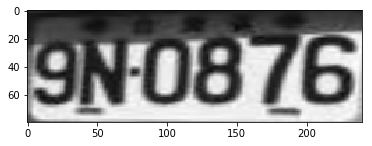

In [30]:
img = np.uint8(Ilp)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [36]:
img_p = '%s/%s_1.jpg'%(outp, bname)
cv2.imwrite(img_p, img)

True

In [2]:
from src.label import dknet_label_conversion
from src.utils import nms

In [3]:
ocr_threshold = .4
ocr_weights = b'data/ocr/ocr-net.weights'
ocr_netcfg  = b'data/ocr/ocr-net.cfg'
ocr_dataset = b'data/ocr/ocr-net.data'

In [4]:
ocr_net  = dn.load_net(ocr_netcfg, ocr_weights, 0)
ocr_meta = dn.load_meta(ocr_dataset)

In [37]:
R,(width,height) = detect(ocr_net, ocr_meta, bytes(img_p, encoding='utf-8') ,thresh=ocr_threshold, nms=None)

In [38]:
print(R)

[(b'8', 0.9269129037857056, (136.7471160888672, 42.093994140625, 38.61524963378906, 49.29275894165039)), (b'8', 0.9184722304344177, (135.34669494628906, 41.8841552734375, 38.57781982421875, 49.89441680908203)), (b'7', 0.9082562327384949, (177.74119567871094, 40.79380416870117, 36.86237716674805, 50.04444885253906)), (b'0', 0.9053994417190552, (99.4676284790039, 39.83834457397461, 37.051612854003906, 50.05493927001953)), (b'0', 0.9018825888633728, (99.62518310546875, 41.99577713012695, 37.814727783203125, 48.45485305786133)), (b'N', 0.9013292789459229, (52.91610336303711, 43.9304313659668, 32.621192932128906, 47.775272369384766)), (b'7', 0.8949450254440308, (177.59913635253906, 39.55986404418945, 38.724430084228516, 48.94673156738281)), (b'9', 0.8948618173599243, (21.071752548217773, 44.4722900390625, 33.85624694824219, 47.70665740966797)), (b'6', 0.8926308155059814, (216.63876342773438, 41.50574493408203, 41.93354415893555, 53.214500427246094)), (b'6', 0.8899863362312317, (214.05735778

In [39]:
L = dknet_label_conversion(R,width,height)
L = nms(L,.45)
L.sort(key=lambda x: x.tl()[0])

In [42]:
lp_str = ''.join([chr(l.cl()) for l in L])
print(lp_str)

9N0876


In [14]:
### For Layout-Independent-alpr
lp_threshold = .01
lp_netcfg = b'data/Layout-Independent-alpr/lp-detection-layout-classification.cfg'
lp_weights = b'data/Layout-Independent-alpr/lp-detection-layout-classification.weights'
lp_dataset = b'data/Layout-Independent-alpr/lp-detection-layout-classification.data'
lp_net  = dn.load_net(lp_netcfg, lp_weights, 0)
lp_meta = dn.load_meta(lp_dataset)
R,_ = detect(lp_net, lp_meta, bytes(img_path, encoding='utf-8') ,thresh=lp_threshold)

In [15]:
r = R[0]
cx,cy,w,h = (np.array(r[2])/np.concatenate( (WH,WH) )).tolist()
tl = np.array([cx - w/2., cy - h/2.])
br = np.array([cx + w/2., cy + h/2.])
label = Label(0,tl,br)
Ilp = crop_region(Iorig,label)

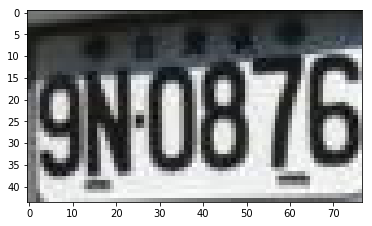

In [16]:
img = np.uint8(Ilp)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [18]:
lp_path = "test/output2/tmp.jpg"
cv2.imwrite(lp_path, img)

True

In [19]:
ocr_threshold = .5
ocr_netcfg = b'data/Layout-Independent-alpr/lp-recognition.cfg'
ocr_weights = b'data/Layout-Independent-alpr/lp-recognition.weights'
ocr_dataset = b'data/Layout-Independent-alpr/lp-recognition.data'
ocr_net  = dn.load_net(ocr_netcfg, ocr_weights, 0)
ocr_meta = dn.load_meta(ocr_dataset)
R,_ = detect(ocr_net, ocr_meta, bytes(lp_path, encoding='utf-8') ,thresh=ocr_threshold)

In [28]:
R, (width,height) = detect(ocr_net, ocr_meta, bytes(lp_path, encoding='utf-8') ,thresh=ocr_threshold)

In [29]:
for ch in R:
    print(ch)

(b'6', 0.9366053342819214, (71.59417724609375, 21.874217987060547, 12.92216968536377, 27.530088424682617))
(b'8', 0.9101043939590454, (45.501407623291016, 24.309606552124023, 11.580662727355957, 25.700111389160156))
(b'9', 0.9075550436973572, (7.494106292724609, 26.72427749633789, 10.595611572265625, 25.200321197509766))
(b'0', 0.9049962759017944, (32.81641387939453, 25.270435333251953, 11.35202407836914, 25.767446517944336))
(b'N', 0.8925364017486572, (18.624605178833008, 26.223064422607422, 11.430229187011719, 25.735427856445312))
(b'7', 0.884575366973877, (57.99533462524414, 23.472951889038086, 13.140913009643555, 28.69397735595703))


In [30]:
lst = sorted(R, key=lambda x: x[2][0])

In [31]:
for ch in lst:
    print(ch)

(b'9', 0.9075550436973572, (7.494106292724609, 26.72427749633789, 10.595611572265625, 25.200321197509766))
(b'N', 0.8925364017486572, (18.624605178833008, 26.223064422607422, 11.430229187011719, 25.735427856445312))
(b'0', 0.9049962759017944, (32.81641387939453, 25.270435333251953, 11.35202407836914, 25.767446517944336))
(b'8', 0.9101043939590454, (45.501407623291016, 24.309606552124023, 11.580662727355957, 25.700111389160156))
(b'7', 0.884575366973877, (57.99533462524414, 23.472951889038086, 13.140913009643555, 28.69397735595703))
(b'6', 0.9366053342819214, (71.59417724609375, 21.874217987060547, 12.92216968536377, 27.530088424682617))


In [33]:
L = dknet_label_conversion(R,width,height)
L = nms(L,.45)
L.sort(key=lambda x: x.tl()[0])
lp_str = ''.join([chr(l.cl()) for l in L])

In [34]:
lp_str

'9N0876'

# Test Weather Plate (Extract from Groundtruth)

In [12]:
def get_acc(inp, outp):
    """
    Compute two strings character by character.
    Input:
        inp: ground truth(str)
        outp: detected result(str)
    Return:
        m: number of groundtruth(int)
        count: number of detect correctly(int)
    """
    m = len(inp)
    count = sum((Counter(inp)&Counter(outp)).values())
    return m, count

In [62]:
### For ALPR-Unscontrained
# inp = "test/AOLP/plate"
inp = "test/weather/plate"
ocr_threshold = .4
ocr_weights = b'data/ocr/ocr-net.weights'
ocr_netcfg  = b'data/ocr/ocr-net.cfg'
ocr_dataset = b'data/ocr/ocr-net.data'
ocr_net  = dn.load_net(ocr_netcfg, ocr_weights, 0)
ocr_meta = dn.load_meta(ocr_dataset)

imgs_paths = image_files_from_folder(inp)
imgs_paths.sort()

total, correct = 0, 0
for img_p in tqdm(imgs_paths, ncols=80):
    label = img_p.split('.')[0].split('_')[-1]
    R,(width,height) = detect(ocr_net, ocr_meta, bytes(img_p, encoding='utf-8') ,thresh=ocr_threshold, nms=None)
    L = dknet_label_conversion(R,width,height)
    L = nms(L,.45)
    L.sort(key=lambda x: x.tl()[0])
    lp_str = ''.join([chr(l.cl()) for l in L])
    t, c = get_acc(label, lp_str)
    total += t
    correct += c

print("Correct =", correct)
print("Total =", total)
print("Accuracy = {:.4f}".format(correct/total))

100%|███████████████████████████████████████████| 54/54 [00:05<00:00,  9.62it/s]

Correct = 214
Total = 337
Accuracy = 0.6350


In [64]:
### For Layout-Independent-alpr
# inp = "test/AOLP/plate"
inp = "test/weather/plate"
ocr_threshold = .5
ocr_netcfg = b'data/Layout-Independent-alpr/lp-recognition.cfg'
ocr_weights = b'data/Layout-Independent-alpr/lp-recognition.weights'
ocr_dataset = b'data/Layout-Independent-alpr/lp-recognition.data'
ocr_net  = dn.load_net(ocr_netcfg, ocr_weights, 0)
ocr_meta = dn.load_meta(ocr_dataset)

imgs_paths = image_files_from_folder(inp)
imgs_paths.sort()

total, correct = 0, 0
for img_p in tqdm(imgs_paths, ncols=80):
    label = img_p.split('.')[0].split('_')[-1]
    R, (width,height) = detect(ocr_net, ocr_meta, bytes(img_p, encoding='utf-8') ,thresh=ocr_threshold)
    L = dknet_label_conversion(R,width,height)
    L = nms(L,.45)
    L.sort(key=lambda x: x.tl()[0])
    lp_str = ''.join([chr(l.cl()) for l in L])
    t, c = get_acc(label, lp_str)
    total += t
    correct += c

print("Correct =", correct)
print("Total =", total)
print("Accuracy = {:.4f}".format(correct/total))

100%|███████████████████████████████████████████| 54/54 [00:13<00:00,  3.98it/s]

Correct = 221
Total = 337
Accuracy = 0.6558


# Test AOLP vehicle (ALPR)

In [3]:
def check_bbox(bb1, bb2):
    '''
    Check if bb2 is completely covered by bb1.
    If so, return True, otherwise return False.
    Input:
        bb1(large region) = [x_min, y_min, x_max, y_max] (all int)
        bb2(small region) = [x_min, y_min, x_max, y_max] (all int)
    '''
    # Assert bb1 is the larger one
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
    if bb1_area < bb2_area:
        temp = bb2
        bb2 = bb1
        bb1 = temp
    
    f1 = bb1[0] <= bb2[0]
    f2 = bb1[1] <= bb2[1]
    f3 = bb1[2] >= bb2[2]
    f4 = bb1[3] >= bb2[3]

    if f1 and f2 and f3 and f4:
        return True
    else:
        return False
    
    
def transfer_label(lab):
    '''
    Transfer label(string) into list(int).
    Input:
        lab: string list ['x_min,y_min,x_max,y_max,plate']
            i.e. ['14,71,83,105,FS799', '215,188,324,240,DP4846']
    Return:
        new_lab: int list [x_min, y_min, x_max, y_max]
            i.e. [[14,71,83,105], [215,188,324,240]]
    '''
    new_lab = []
    for l in lab:
        _l = l.split(',')
        x1 = int(_l[0])
        y1 = int(_l[1])
        x2 = int(_l[2])
        y2 = int(_l[3])
        new_lab.append([x1, y1, x2, y2])
    
    return new_lab


def transfer_pred(pred):
    '''
    Transfer predictions of Darknet into list.
    Input: a list of obj [(class, score, (x_center, y_center, w, h))]
        i.e.
        [(b'car', 0.91, (178.58, 115.88, 289.27, 234.73)), 
         (b'car', 0.76, (30.51, 94.46, 58.90, 44.07))]
    
    Return: a list of obj [x_min, y_min, x_max, y_max] (all int)
        i.e.
        [[34, 0, 322, 352], [1, 72, 59, 116]]
    '''
    objs = []
    for r in pred:
        cx, cy, w, h = r[2]
        x_min = max(int(cx - w/2), 0)
        y_min = max(int(cy - h/2), 0)
        x_max = int(cx + w/2)
        y_max = int(cy + h/2)
        objs.append([x_min, y_min, x_max, y_max])
    return objs


def get_num(dic):
    '''
    Compute the number of plates(vehicles).
    '''
    total = 0
    for k, v in dic.items():
        total += len(v)
    return total

### Create Ground truth Label

In [53]:
"""
Create label dictionary.
Format: dic = {key: file_name(str), value: [obj1(str), obj2(str), ...]}
        obj format = 'x_min, y_min, x_max, y_max, plate'
   i.e. dic['train_LE_3'] = ['266,199,350,242,2972KK']
        dic['train_LE_33'] = ['14,71,83,105,FS799', '215,188,324,240,DP4846']
"""
label_data = {}
# label_txt = "test/AOLP/label.txt"
label_txt = "test/weather/label.txt"
label_file = open(label_txt, 'r')
lines = label_file.readlines()
for line in lines:
    l = line.strip().split(' ')
    name = l[0]
    plates = l[1:]
    label_data[name] = plates

### Detect Vehicle from All Images

In [6]:
### For ALPR-Unscontrained
inp = "test/AOLP/original"
# inp = "test/weather/original"
vehicle_threshold = .5
vehicle_weights = b'data/vehicle-detector/yolo-voc.weights'
vehicle_netcfg  = b'data/vehicle-detector/yolo-voc.cfg'
vehicle_dataset = b'data/vehicle-detector/voc.data'

vehicle_net  = dn.load_net(vehicle_netcfg, vehicle_weights, 0)
vehicle_meta = dn.load_meta(vehicle_dataset) 
imgs_paths = image_files_from_folder(inp)
imgs_paths.sort()

correct_vehicle = {}
pbar = tqdm(imgs_paths, ncols=80)
for img_p in pbar:
    bname = basename(splitext(img_p)[0])
    labels = transfer_label(label_data[bname]) # [num, 4]
    
    R,_ = detect(vehicle_net, vehicle_meta, bytes(img_p, encoding='utf-8') ,thresh=vehicle_threshold)
    objs = transfer_pred(R) # [num, 4]
    
    correct_objs = []
    for i, lab in enumerate(labels):
        for obj in objs:
            correct = check_bbox(obj, lab)
            if correct:
                obj.append(i)
                correct_objs.append(obj)
                break
    correct_vehicle[bname] = correct_objs
pbar.close()
    
all_v = get_num(label_data)
pred_v = get_num(correct_vehicle)
print("Correct =", pred_v)
print("Total =", all_v)
print("Accuracy = {:.4f}".format(pred_v/all_v))

100%|███████████████████████████████████████| 2049/2049 [23:57<00:00,  1.43it/s]

Correct = 1962
Total = 2161
Accuracy = 0.9079


### Create Vehicle Images from Detection

In [5]:
! rm -r "test/temp_vehicle"

In [7]:
### Create temp image for vehicle
### correct_vehicle[key] = [num_obj, 5(x1, y1, x2, y2, idx)]
if not exists("test/temp_vehicle"):
    makedirs("test/temp_vehicle")
for k, v in tqdm(correct_vehicle.items(), ncols=80):
    if len(v)>0:
        img_p = "test/AOLP/original/{}.jpg".format(k)
#         img_p = "test/weather/original/{}.jpg".format(k)
        img = cv2.imread(img_p)
        for _v in v:
            img_vehicle = img[_v[1]:_v[3], _v[0]:_v[2]]
            save_p = "test/temp_vehicle/{}-{}.jpg".format(k, _v[4])
            cv2.imwrite(save_p, img_vehicle)

100%|██████████████████████████████████████| 2049/2049 [00:10<00:00, 200.39it/s]


In [8]:
def get_iou(bb1, bb2):
    '''
    Input:
        bb1(groundtruth) = [left_top_x, y, right_bottom_x, y]
        bb2(predict_point) = [left_top_x, y, right_bottom_x, y]
    '''
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

### Detect Plate from Vehicle Images

In [9]:
### Detect plate
inp = "test/temp_vehicle"
imgs_paths = image_files_from_folder(inp)
imgs_paths.sort()

lp_threshold = .5
lp_model = "data/lp-detector/wpod-net_update1.h5"
wpod_net = load_model(lp_model)

pred_labels = {}
for img_p in tqdm(imgs_paths, ncols=80):
    Ivehicle = cv2.imread(img_p)
    ratio = float(max(Ivehicle.shape[:2]))/min(Ivehicle.shape[:2])
    side  = int(ratio*288.)
    bound_dim = min(side + (side%(2**4)),608)
    Llp, LlpImgs, _ = detect_lp(wpod_net,im2single(Ivehicle),bound_dim,2**4,(240,80),lp_threshold)
    
    wh = getWH(Ivehicle.shape[:2])
    file_name = splitext(basename(img_p))[0]
    bname, i = file_name.split('-')
    for obj in correct_vehicle[bname]:
        if obj[-1] == int(i):
            dx = obj[0]
            dy = obj[1]
            break
    
    plates = []
    for lp, Ilp in zip(Llp, LlpImgs):
        x1, y1 = lp.tl() * wh
        x2, y2 = lp.br() * wh
        bbox = [int(x1)+dx, int(y1)+dy, int(x2)+dx, int(y2)+dy]
        pla = {'bbox': bbox, 'plate': Ilp, 'num': int(i)}
        plates.append(pla)
    
    if bname in pred_labels:
        pred_labels[bname] += plates
    else:
        pred_labels[bname] = plates

100%|███████████████████████████████████████| 1943/1943 [01:34<00:00, 20.67it/s]


In [10]:
### Compute accuracy
total = 0
correct = 0
correct_plate = {}
for k, v in tqdm(label_data.items(), ncols=80):
    gt = transfer_label(label_data[k])
    total += len(gt)
    if k in pred_labels:
        preds = pred_labels[k]  # preds = [dic1, dic2, ...]
        for g in gt:
            for p in preds: # p = {'bbox': [x1, y1, x2, y2], 'plate': Ilp, 'num': int(i)}
                iou = get_iou(g, p['bbox'])
                if iou >= 0.5:
                    correct += 1
                    if k in correct_plate:
                        correct_plate[k] += [p]
                    else:
                        correct_plate[k] = [p]
                    break
                    
print("Correct =", correct)
print("Total =", total)
print("Accuracy = {:.4f}".format(correct/total))

100%|████████████████████████████████████| 2053/2053 [00:00<00:00, 67230.16it/s]

Correct = 1736
Total = 2161
Accuracy = 0.8033


### Save Plate Image

In [11]:
save_dir = "test/temp_plate"
if not exists(save_dir):
    makedirs(save_dir)

for k, v in tqdm(correct_plate.items(), ncols=80):  # k = original_file_name, v = [dic1, dic2, ...]
    for _v in v:  # _v = {'bbox': [x1, y1, x2, y2], 'plate': Ilp, 'num': int(i)}
        Ilp = _v['plate']
        Ilp = (Ilp*255).astype(int)
        img_plate = np.uint8(Ilp)

        save_p = "{}/{}-{}.jpg".format(save_dir, k, _v['num'])
        cv2.imwrite(save_p, img_plate)

100%|█████████████████████████████████████| 1699/1699 [00:01<00:00, 1089.52it/s]


### Reconize Plate from detected image

In [13]:
### Compute number of characters of all plates
total = 0
for k, v in label_data.items():
    for _v in v:
        p = _v.split(',')[-1]
        total += len(p)

In [14]:
inp = "test/temp_plate"
imgs_paths = image_files_from_folder(inp)
imgs_paths.sort()

ocr_threshold = .4
ocr_weights = b'data/ocr/ocr-net.weights'
ocr_netcfg  = b'data/ocr/ocr-net.cfg'
ocr_dataset = b'data/ocr/ocr-net.data'
ocr_net  = dn.load_net(ocr_netcfg, ocr_weights, 0)
ocr_meta = dn.load_meta(ocr_dataset)

correct = 0
for img_p in tqdm(imgs_paths, ncols=80):
    R,(width,height) = detect(ocr_net, ocr_meta, bytes(img_p, encoding='utf-8') ,thresh=ocr_threshold, nms=None)
    L = dknet_label_conversion(R,width,height)
    L = nms(L,.45)
    L.sort(key=lambda x: x.tl()[0])
    lp_str = ''.join([chr(l.cl()) for l in L])
    
    file_name = splitext(basename(img_p))[0]
    bname, i = file_name.split('-')
    label = label_data[bname][int(i)].split(',')[-1]
    _, c = get_acc(label, lp_str)
    correct += c

print("Correct =", correct)
print("Total =", total)
print("Accuracy = {:.4f}".format(correct/total))

100%|███████████████████████████████████████| 1729/1729 [02:52<00:00, 10.03it/s]

Correct = 10153
Total = 12890
Accuracy = 0.7877


# Test AOLP vehicle (Layout)

### Detect Vehicle

In [54]:
### Detect vehicle
# inp = "test/AOLP/original"
inp = "test/weather/original"
vehicle_threshold = .5
vehicle_weights = b'data/Layout-Independent-alpr/vehicle-detection.weights'
vehicle_netcfg  = b'data/Layout-Independent-alpr/vehicle-detection.cfg'
vehicle_dataset = b'data/Layout-Independent-alpr/vehicle-detection.data'

vehicle_net  = dn.load_net(vehicle_netcfg, vehicle_weights, 0)
vehicle_meta = dn.load_meta(vehicle_dataset) 
imgs_paths = image_files_from_folder(inp)
imgs_paths.sort()

correct_vehicle = {}
pbar = tqdm(imgs_paths, ncols=80)
for img_p in pbar:
    bname = basename(splitext(img_p)[0])
    labels = transfer_label(label_data[bname]) # [num, 4]
    
    R,_ = detect(vehicle_net, vehicle_meta, bytes(img_p, encoding='utf-8') ,thresh=vehicle_threshold)
    objs = transfer_pred(R) # [num, 4]
    
    correct_objs = []
    for i, lab in enumerate(labels):
        for obj in objs:
            correct = check_bbox(obj, lab)
            if correct:
                obj.append(i)
                correct_objs.append(obj)
                break
    correct_vehicle[bname] = correct_objs
pbar.close()
    
all_v = get_num(label_data)
pred_v = get_num(correct_vehicle)
print("Correct =", pred_v)
print("Total =", all_v)
print("Accuracy = {:.4f}".format(pred_v/all_v))

100%|███████████████████████████████████████████| 47/47 [00:57<00:00,  1.22s/it]

Correct = 31
Total = 54
Accuracy = 0.5741


In [55]:
! rm -r "test/temp_vehicle"

In [56]:
! rm -r "test/temp_plate"

### Create Vehicle Images

In [57]:
### Create temp image for vehicle
### correct_vehicle[key] = [num_obj, 4(x1, y1, x2, y2)]
if not exists("test/temp_vehicle"):
    makedirs("test/temp_vehicle")
for k, v in tqdm(correct_vehicle.items(), ncols=80):
    if len(v)>0:
#         img_p = "test/AOLP/original/{}.jpg".format(k)
        img_p = "test/weather/original/{}.jpg".format(k)
        img = cv2.imread(img_p)
        for _v in v:
            img_vehicle = img[_v[1]:_v[3], _v[0]:_v[2]]
            save_p = "test/temp_vehicle/{}-{}.jpg".format(k, _v[4])
            cv2.imwrite(save_p, img_vehicle)

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 160.31it/s]


### Detect Plate from Vehicle Images

In [58]:
### Detect plate
inp = "test/temp_vehicle"
lp_threshold = .5
lp_weights = b'data/Layout-Independent-alpr/lp-detection-layout-classification.weights'
lp_netcfg  = b'data/Layout-Independent-alpr/lp-detection-layout-classification.cfg'
lp_dataset = b'data/Layout-Independent-alpr/lp-detection-layout-classification.data'

lp_net  = dn.load_net(lp_netcfg, lp_weights, 0)
lp_meta = dn.load_meta(lp_dataset) 
imgs_paths = image_files_from_folder(inp)
imgs_paths.sort()

pred_labels = {}
for img_p in tqdm(imgs_paths, ncols=80):
    Ivehicle = cv2.imread(img_p)
    wh = getWH(Ivehicle.shape[:2])
    file_name = splitext(basename(img_p))[0]
    bname, i = file_name.split('-')
    for obj in correct_vehicle[bname]:
        if obj[-1] == int(i):
            dx = obj[0]
            dy = obj[1]
            break
    
    R,_ = detect(lp_net, lp_meta, bytes(img_p, encoding='utf-8') ,thresh=lp_threshold)
    objs = transfer_pred(R) # [num, 4]
    
    plates = []
    for lp in objs:
        x1 = lp[0] + dx
        y1 = lp[1] + dy
        x2 = lp[2] + dx
        y2 = lp[3] + dy
        bbox = [x1, y1, x2, y2]
        plates.append({'bbox': bbox, 'num': int(i), 'plate': lp}) # bbox: coordinate for GT, plate: coordinate for vehicle
    
    if bname in pred_labels:
        pred_labels[bname] += plates
    else:
        pred_labels[bname] = plates

100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


In [59]:
total = 0
correct = 0
correct_plate = {}
for k, v in tqdm(label_data.items(), ncols=80):
    gt = transfer_label(label_data[k])
    total += len(gt)
    if k in pred_labels:
        preds = pred_labels[k]
        for g in gt:
            for p in preds:
                iou = get_iou(g, p['bbox'])
                if iou >= 0.5:
                    correct += 1
                    if k in correct_plate:
                        correct_plate[k] += [p]
                    else:
                        correct_plate[k] = [p]
                    break
                    
print("Correct =", correct)
print("Total =", total)
print("Accuracy = {:.4f}".format(correct/total))

100%|████████████████████████████████████████| 47/47 [00:00<00:00, 59270.08it/s]

Correct = 14
Total = 54
Accuracy = 0.2593


In [60]:
save_dir = "test/temp_plate"
if not exists(save_dir):
    makedirs(save_dir)

for k, v in tqdm(correct_plate.items(), ncols=80):  # k = original_file_name, v = [dic1, dic2, ...]
    for _v in v:  # _v = {'bbox': [x1, y1, x2, y2], 'num': int(i)}
        img_p = "test/temp_vehicle/{}-{}.jpg".format(k, _v['num'])
        img = cv2.imread(img_p)
        b = _v['plate']
        img_plate = img[b[1]:b[3], b[0]:b[2]]
        save_p = "{}/{}-{}.jpg".format(save_dir, k, _v['num'])
        cv2.imwrite(save_p, img_plate)

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 489.85it/s]


In [61]:
### Compute number of characters of all plates
total = 0
for k, v in label_data.items():
    for _v in v:
        p = _v.split(',')[-1]
        total += len(p)

### Recognize plate
inp = "test/temp_plate"
ocr_threshold = .5
ocr_netcfg = b'data/Layout-Independent-alpr/lp-recognition.cfg'
ocr_weights = b'data/Layout-Independent-alpr/lp-recognition.weights'
ocr_dataset = b'data/Layout-Independent-alpr/lp-recognition.data'
ocr_net  = dn.load_net(ocr_netcfg, ocr_weights, 0)
ocr_meta = dn.load_meta(ocr_dataset)

imgs_paths = image_files_from_folder(inp)
imgs_paths.sort()

correct = 0
for img_p in tqdm(imgs_paths, ncols=80):
    R, (width,height) = detect(ocr_net, ocr_meta, bytes(img_p, encoding='utf-8') ,thresh=ocr_threshold)
    L = dknet_label_conversion(R,width,height)
    L = nms(L,.45)
    L.sort(key=lambda x: x.tl()[0])
    lp_str = ''.join([chr(l.cl()) for l in L])
    
    file_name = splitext(basename(img_p))[0]
    bname, i = file_name.split('-')
    label = label_data[bname][int(i)].split(',')[-1]
    _, c = get_acc(label, lp_str)
    correct += c

print("Correct =", correct)
print("Total =", total)
print("Accuracy = {:.4f}".format(correct/total))

100%|███████████████████████████████████████████| 14/14 [00:03<00:00,  3.95it/s]

Correct = 58
Total = 337
Accuracy = 0.1721
